In [52]:
#Importing neccessary libararies
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import numpy as np
import string
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.optim as optim
import warnings
import gensim
import gensim.downloader
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
#importing pretrained word2vector model on google news
word2vec_model = gensim.downloader.load('word2vec-google-news-300')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/utsavsuthar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/utsavsuthar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/utsavsuthar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [74]:
#Reading train and test data from the file
train_df = pd.read_csv("../NLP3/train.csv")
test_df = pd.read_csv("../NLP3/test.csv")
test_df.head()

,index,text,label
0,0,Detainees seen as minimal threat WASHINGTON --...,0
1,1,Japan's army works out plan to cope with North...,0
2,2,UN council arrives in Nairobi UN Security Coun...,0
3,3,APEC Ministers Urge New Effort on Trade Talks ...,0
4,4,At Least Five Dead in Russia Mine Blast (Reute...,0


In [75]:
#patter to remove HTML Tags 
pattern1 = r"&lt;.*?&gt;|#[0-9]*;|\([^)]*\)|\d+(st|nd|rd|th)|\d+"
punch_set = set(string.punctuation)
elements = {"'s","``","''","...","--"}
punch_set.update(elements)
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    # replacing "\\" with space
    text = text.replace('\\', ' ')
    text = re.sub(pattern1,'',text) 
    # print(text)
    #using nltk word tokenizer to tokeninze the text
    tokens = word_tokenize(text)
    # print(tokens)
    updated_tokens  = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in punch_set and tok not in stop_words and len(lemmatizer.lemmatize(tok)) >1]
    text = " ".join(updated_tokens)
    return text


In [76]:
text = "Dallas. Mr. Morning. mr. mrs. News\\ to Lose Jobs  NEW YORK (Reuters) - Belo Corp. &lt;A HREF=""http://www.investor.reuters.com/FullQuote.aspx?ticker=BLC.N target=/stocks/quickinfo/fullquote""&gt;BLC.N&lt;/A&gt; said on Wednesday  it would cut more than 3 percent of its work force, mostly at  its Dallas Morning News, which is grappling with a recent  scandal into inflated circulation data provided to advertisers."
output = preprocess(text)
(output)

'dallas mr. morning mr. mrs. news lose job new york belo corp. blc.n said wednesday would cut percent work force mostly dallas morning news grappling recent scandal inflated circulation data provided advertiser'

In [77]:
train_df['preprocessed_text'] = train_df['text'].apply(preprocess)
test_df['preprocessed_text'] = test_df['text'].apply(preprocess)
# save preprocessed data into preprocessed train and test csv file
train_df.to_csv("preprocessed_train.csv")
test_df.to_csv("preprocessed_test.csv")

In [78]:
# spliting train data into train and validation data.
X_Train, X_Val, Y_Train, Y_Val = train_test_split(train_df['preprocessed_text'],train_df['label'], train_size=0.9, random_state=42, shuffle=True)                                  
X_Train=X_Train.reset_index(drop=True)
X_Val=X_Val.reset_index(drop=True)
Y_Train=Y_Train.reset_index(drop=True)
Y_Val=Y_Val.reset_index(drop=True)
X_Test = test_df['preprocessed_text']
Y_Test = test_df['label']

In [79]:

X_train_tokenized = [simple_preprocess(text) for text in X_Train]
X_val_tokenized = [simple_preprocess(text) for text in X_Val]
X_test_tokenized = [simple_preprocess(text) for text in X_Test]
combined_data = X_train_tokenized + X_val_tokenized
vocabulary = gensim.corpora.Dictionary(combined_data)
# print(vocabulary)
# removing words which has document frequency less than 3 and has present in more than 95% of the document
vocabulary.filter_extremes(no_below=3, no_above=0.95)
vector_size = word2vec_model.vector_size
len(vocabulary)


3238

In [80]:
#function to get average embedding of the sentence
def get_avg_embedding(text,model):
    vect_avg_embedding=[]
    words = simple_preprocess(text)
    for word in words:
        if word in vocabulary.token2id:
            try:
                vect_avg_embedding.append(model.get_vector(word))
            except KeyError:
                pass
    if len(vect_avg_embedding)>0:
        return sum(vect_avg_embedding)/len(vect_avg_embedding)
    else:
        return [0]*vector_size

In [81]:
X_train_vect_avg = []
for text in X_Train:
    X_train_vect_avg.append(get_avg_embedding(text,word2vec_model))
X_val_vect_avg = []
for text in X_Val:
    X_val_vect_avg.append(get_avg_embedding(text,word2vec_model))
X_test_vect_avg = []
for text in X_Test:
    X_test_vect_avg.append(get_avg_embedding(text,word2vec_model))
# len(X_test_vect_avg)

In [82]:
y_val = Y_Val.values
y_train = Y_Train.values
y_test = Y_Test.values

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Convert the lists of embeddings to PyTorch tensors
X_train = torch.tensor(X_train_vect_avg, dtype=torch.float32)
X_train = X_train.view(len(X_train_vect_avg), -1)
X_val = torch.tensor(X_val_vect_avg, dtype=torch.float32)
X_val = X_val.view(len(X_val_vect_avg),-1)
y_train = torch.tensor(y_train, dtype=torch.long) 
y_val = torch.tensor(y_val, dtype=torch.long)      
X_test= torch.tensor(X_test_vect_avg, dtype=torch.float32)
X_test = X_test.view(len(X_test_vect_avg), -1)
y_test = torch.tensor(y_test, dtype=torch.long) 


from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
batch_size = 32

# Create custom dataset and dataloader
dataset = CustomDataset(X_train,y_train)
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataset = CustomDataset(X_val,y_val)
val_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataset = CustomDataset(X_test,y_test)
test_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Defining a simple feedforward neural network model for multi-class classification
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.bn1 = nn.BatchNorm1d(hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


In [84]:

# Defining hyperparameters
input_size = X_train.shape[1]
hidden_size = 256
num_classes = len(np.unique(y_train))  
learning_rate = 0.0001
num_epochs = 20
# Initialize the model
model = NeuralNetwork(input_size, hidden_size, num_classes)

# Define loss function and optimizer for multi-class classification
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
best_val_loss = float('inf')  # Initialize with a large value
best_val_accuracy = 0.0
# Train the model
from sklearn.metrics import accuracy_score
for epoch in range(num_epochs):
    running_train_loss = 0.0
    running_val_loss = 0.0
    for inputs, labels in train_dataloader:
        # Forward pass
        outputs = model(inputs)
        # Compute the training loss
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Accumulate training loss for printing
        running_train_loss += loss.item()

    # Validation
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for val_inputs, val_labels in val_dataloader:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            running_val_loss += val_loss.item()  
            # Calculate accuracy
            _, predicted = torch.max(val_outputs, 1)
            all_predictions.extend(predicted.tolist())
            all_labels.extend(val_labels.tolist())
        # Print average validation loss for the epoch
        avg_val_loss = running_train_loss/len(train_dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_train_loss/len(train_dataloader):.4f} , Validation Loss: {running_val_loss/len(val_dataloader):.4f}')
        # Calculate accuracy
        val_accuracy = accuracy_score(all_labels, all_predictions)
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy:.4f}')
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model_loss.pth')
        # print("Saved model with lowest validation loss")
    model.train()  # Set model back to training mode


Epoch [1/20], Training Loss: 1.1846 , Validation Loss: 1.1451
Epoch [1/20], Validation Accuracy: 0.8350
Epoch [2/20], Training Loss: 0.7742 , Validation Loss: 0.6201
Epoch [2/20], Validation Accuracy: 0.8300
Epoch [3/20], Training Loss: 0.5523 , Validation Loss: 0.5088
Epoch [3/20], Validation Accuracy: 0.8600
Epoch [4/20], Training Loss: 0.4707 , Validation Loss: 0.4309
Epoch [4/20], Validation Accuracy: 0.8700
Epoch [5/20], Training Loss: 0.4286 , Validation Loss: 0.4566
Epoch [5/20], Validation Accuracy: 0.8700
Epoch [6/20], Training Loss: 0.3943 , Validation Loss: 0.3974
Epoch [6/20], Validation Accuracy: 0.8750
Epoch [7/20], Training Loss: 0.3633 , Validation Loss: 0.3964
Epoch [7/20], Validation Accuracy: 0.8600
Epoch [8/20], Training Loss: 0.3310 , Validation Loss: 0.3828
Epoch [8/20], Validation Accuracy: 0.8700
Epoch [9/20], Training Loss: 0.3095 , Validation Loss: 0.4013
Epoch [9/20], Validation Accuracy: 0.8650
Epoch [10/20], Training Loss: 0.2937 , Validation Loss: 0.3813
E

In [85]:
model = NeuralNetwork(input_size, hidden_size, num_classes)
# Load the saved state dict
model.load_state_dict(torch.load('best_model_loss.pth'))
# Evaluate the model on training data
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = model(X_train)
    _, predictions = torch.max(outputs, 1)
    accuracy = (predictions == y_train).float().mean()
    print(f'Training Accuracy: {accuracy.item()*100:.2f}%')
# Evaluate the model on validation data
with torch.no_grad():
    outputs = model(X_val)
    _, predictions = torch.max(outputs, 1)
    accuracy = (predictions == y_val).float().mean()
    print(f'Validation Accuracy: {accuracy.item()*100:.2f}%')
# Evaluate the model on test data
with torch.no_grad():
    outputs = model(X_test)
    _, predictions = torch.max(outputs, 1)
    accuracy = (predictions == y_test).float().mean()
    print(f'Testing Accuracy: {accuracy.item()*100:.2f}%')

Training Accuracy: 98.39%
Validation Accuracy: 86.00%
Testing Accuracy: 84.80%


In [86]:
from sklearn.metrics import f1_score, accuracy_score
# test_accuracy = accuracy(y_test,predictions)
# print("Test Accuracy: ",test_accuracy)
f1 = f1_score(y_test, predictions,average='micro')
print("F1 score:", f1)

F1 score: 0.848


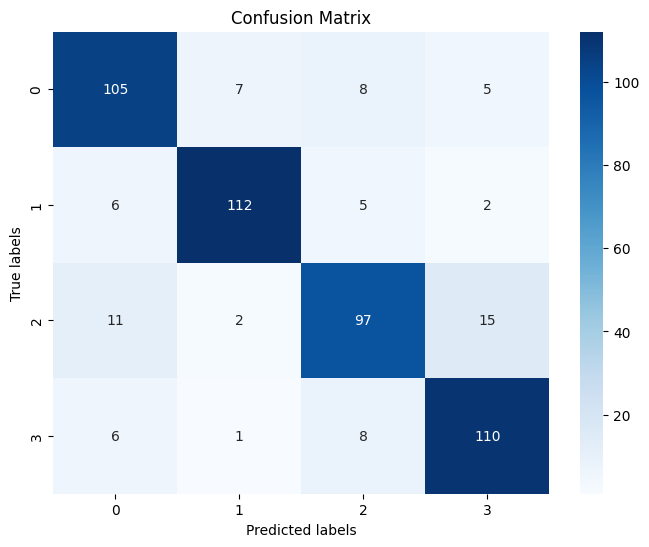

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       125
           1       0.92      0.90      0.91       125
           2       0.82      0.78      0.80       125
           3       0.83      0.88      0.86       125

    accuracy                           0.85       500
   macro avg       0.85      0.85      0.85       500
weighted avg       0.85      0.85      0.85       500



In [87]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Calculate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Calculate classification report
cr = classification_report(y_test, predictions)

# Plot confusion matrix
# print("Confusion Matrix")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=np.unique(y_test), yticklabels=np.unique([predictions]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(cr)


In [88]:
# test_df= test_df.drop(columns=['preprocessed_text','preds'],axis=1)
df = pd.read_csv("../NLP3/test.csv")
test_df_copy =df
test_df_copy.insert(loc=3, column='preds', value=predictions)
#saving prediction into w2v_test.csv file 
test_df_copy.to_csv("w2v_test.csv")